In [110]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import time
from datetime import datetime

In [111]:
# Read in bitcoin prices csv
bitcoin_prices = pd.read_csv('BitCoin_hist_data.csv')
bitcoin_prices.date = pd.to_datetime(bitcoin_prices.date)
bitcoin_prices = bitcoin_prices[bitcoin_prices.date.dt.year >= 2014]

In [112]:
# Bitcoin google trends
bitcoin_gtrends = pd.read_csv('google_trends_bitcoin_2014.csv')
bitcoin_gtrends.date = pd.to_datetime(bitcoin_gtrends.date)

In [113]:
# Bitcoin tweet volumes
bitcoin_tweet_volumes = pd.read_csv('tweet_volumes_bitcoin_2014.csv')
bitcoin_tweet_volumes = bitcoin_tweet_volumes[['date','num_tweets']]
bitcoin_tweet_volumes.date = pd.to_datetime(bitcoin_tweet_volumes.date, format = '%Y-%m-%d')

In [114]:
# Interpolate missing tweet volumes
bitcoin_tweet_volumes.num_tweets = bitcoin_tweet_volumes.num_tweets.interpolate()

In [115]:
bitcoin_gtrends

,date,bitcoin_unscaled,bitcoin_monthly,isPartial,scale,bitcoin
0,2014-01-01,63,8.0,False,0.08,5.04
1,2014-01-02,68,8.0,NaN,0.08,5.44
2,2014-01-03,77,8.0,NaN,0.08,6.16
3,2014-01-04,63,8.0,NaN,0.08,5.04
4,2014-01-05,71,8.0,NaN,0.08,5.68
...,...,...,...,...,...,...
2917,2021-12-27,43,35.0,NaN,0.35,15.05
2918,2021-12-28,46,35.0,NaN,0.35,16.10
2919,2021-12-29,45,35.0,NaN,0.35,15.75
2920,2021-12-30,44,35.0,NaN,0.35,15.40


# w/ google trends & tweet volumes

In [116]:
# Modeling with just google trends and tweet volumes
df_tmp = bitcoin_prices.merge(bitcoin_gtrends, on = 'date')[['date','close','bitcoin']]
df = df_tmp.merge(bitcoin_tweet_volumes, on = 'date')
df = df.set_index('date')

In [117]:
df.corr()

,close,bitcoin,num_tweets
close,1.000000,0.727929,0.801102
bitcoin,0.727929,1.000000,0.785577
num_tweets,0.801102,0.785577,1.000000


In [118]:
# new_df = pd.concat([df[['bitcoin','num_tweets']].shift(-i),df['close']], axis = 1).dropna()
# new_df['prev_price'] = new_df['close'].shift(1).dropna()
# new_df['prev_tweet_volume'] = new_df['num_tweets'].shift(1).dropna()
# new_df = new_df.dropna()
# X = new_df[['bitcoin','num_tweets','prev_price','prev_tweet_volume']]
# y = new_df['close']

In [119]:
X = df[['bitcoin','num_tweets']]
y = df.close

In [120]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)
X_train = X[X.index <= pd.to_datetime('2019-12-31')]
X_test = X[X.index > pd.to_datetime('2019-12-31')]
y_train = y[y.index <= pd.to_datetime('2019-12-31')]
y_test = y[y.index > pd.to_datetime('2019-12-31')]

In [121]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [122]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [123]:
import pickle

pickle.dump(lr, open('lr_tweet_bitcoin.pkl', 'wb'))

In [124]:
df.append({'close':1,'bitcoin':1.11,'num_tweets':1}, ignore_index = True)

<ipython-input-124-a794898eb10c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append({'close':1,'bitcoin':1.11,'num_tweets':1}, ignore_index = True)


,close,bitcoin,num_tweets
0,384.63,3.72,8193.0
1,435.14,4.00,15039.0
2,437.65,3.88,14907.0
3,427.60,2.88,7582.0
4,478.38,2.64,10674.0
...,...,...,...
2820,46471.70,16.10,118350.0
2821,47129.66,15.75,111906.0
2822,46197.31,15.40,126646.0
2823,47737.35,14.35,116434.0


In [125]:
# trying shifting predictors back 0-7 days

for i in range(8):
    new_df = pd.concat([df[['bitcoin','num_tweets']].shift(-i),df['close']], axis = 1).dropna()
    new_df['prev_price'] = new_df['close'].shift(1)
    new_df['prev_tweet_volumne'] = new_df['num_tweets'].shift(1)
    X = new_df[['bitcoin','num_tweets']]
    y = new_df['close']
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    r2_cv_score = sum(cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='r2', 
                                  n_jobs=-1)) / 10
    
    print('Training R2 score shifting back predictors {} days: {}'.format(i,r2_score(y_train, y_train_pred)))
    print('Testing R2 score shifting back predictors {} days: {}'.format(i,r2_score(y_test, y_test_pred)))
    print('CV R2 score shifting back predictors {} days: {}'.format(i,r2_cv_score))
    print('--- --- --- ---')

Training R2 score shifting back predictors 0 days: 0.6782375668389579
Testing R2 score shifting back predictors 0 days: 0.6361062225472554
CV R2 score shifting back predictors 0 days: 0.6708574222001615
--- --- --- ---
Training R2 score shifting back predictors 1 days: 0.6665917191394195
Testing R2 score shifting back predictors 1 days: 0.6689453338435125
CV R2 score shifting back predictors 1 days: 0.6535384617397422
--- --- --- ---
Training R2 score shifting back predictors 2 days: 0.6621932106548494
Testing R2 score shifting back predictors 2 days: 0.6764650439020085
CV R2 score shifting back predictors 2 days: 0.6582142473228082
--- --- --- ---
Training R2 score shifting back predictors 3 days: 0.6643338963824852
Testing R2 score shifting back predictors 3 days: 0.6639320407166606
CV R2 score shifting back predictors 3 days: 0.6578359580023454
--- --- --- ---
Training R2 score shifting back predictors 4 days: 0.6705213275256007
Testing R2 score shifting back predictors 4 days: 0.65

In [126]:
i = 3
new_df = pd.concat([df[['bitcoin','num_tweets']].shift(-i),df['close']], axis = 1).dropna()
new_df['prev_price'] = new_df['close'].shift(1)
new_df['prev_tweet_volume'] = new_df['num_tweets'].shift(1)
new_df = new_df.dropna()

#X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X_scaled, y, X.index,test_size = 0.3)
train = new_df[new_df.index.year <= 2019]
test = new_df[new_df.index.year > 2019]

X_train = train[['bitcoin','num_tweets','prev_price','prev_tweet_volume']]
y_train = train['close']

X_test = test[['bitcoin','num_tweets','prev_price','prev_tweet_volume']]
y_test = test['close']

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

lr = GradientBoostingRegressor()
lr.fit(X_train, y_train)

GradientBoostingRegressor()

In [127]:
#preds_train = pd.DataFrame(lr.predict(X_train), columns = ['train_preds'])
train['preds'] = lr.predict(X_train)
test['preds'] = lr.predict(X_test)

<ipython-input-127-727dbfd5267c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preds'] = lr.predict(X_train)
<ipython-input-127-727dbfd5267c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds'] = lr.predict(X_test)


In [128]:
print(r2_score(y_train, train['preds']))
print(r2_score(y_test, test['preds']))

0.998088414188629
-0.24090753789373887


In [129]:
print(mean_squared_error(y_train, train['preds'])**0.5)
print(mean_squared_error(y_test, test['preds'])**0.5)

169.43313033434976
21901.562592846916


In [130]:
r2_cv_score = sum(cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='r2', 
                                  n_jobs=-1)) / 10

In [131]:
r2_cv_score

0.8927831825933572

In [132]:
mse_cv_score = -sum(cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='neg_root_mean_squared_error', 
                                  n_jobs=-1)) / 10

In [133]:
mse_cv_score**0.5

18.72020675048135

In [134]:
mape_cv_score = -sum(cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  n_jobs=-1)) / 10

In [135]:
mape_cv_score

0.05930109447034143

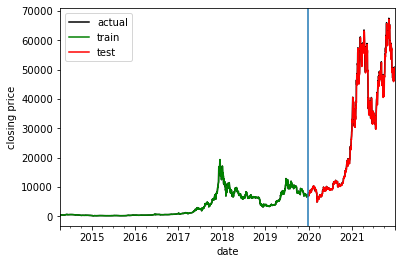

In [30]:
new_df['close'].plot(c = 'black', label = 'actual')
train['preds'].plot(c = 'green', label = 'train')
test['preds'].plot(c = 'red', label = 'test')
plt.legend()
plt.ylabel('closing price')
plt.axvline(datetime(2019, 12, 31))
plt.show()